Relatório de Performance (Random Forest):
              precision    recall  f1-score   support

           0       0.89      0.66      0.76       706
           1       0.50      0.81      0.62       294

    accuracy                           0.71      1000
   macro avg       0.70      0.74      0.69      1000
weighted avg       0.78      0.71      0.72      1000



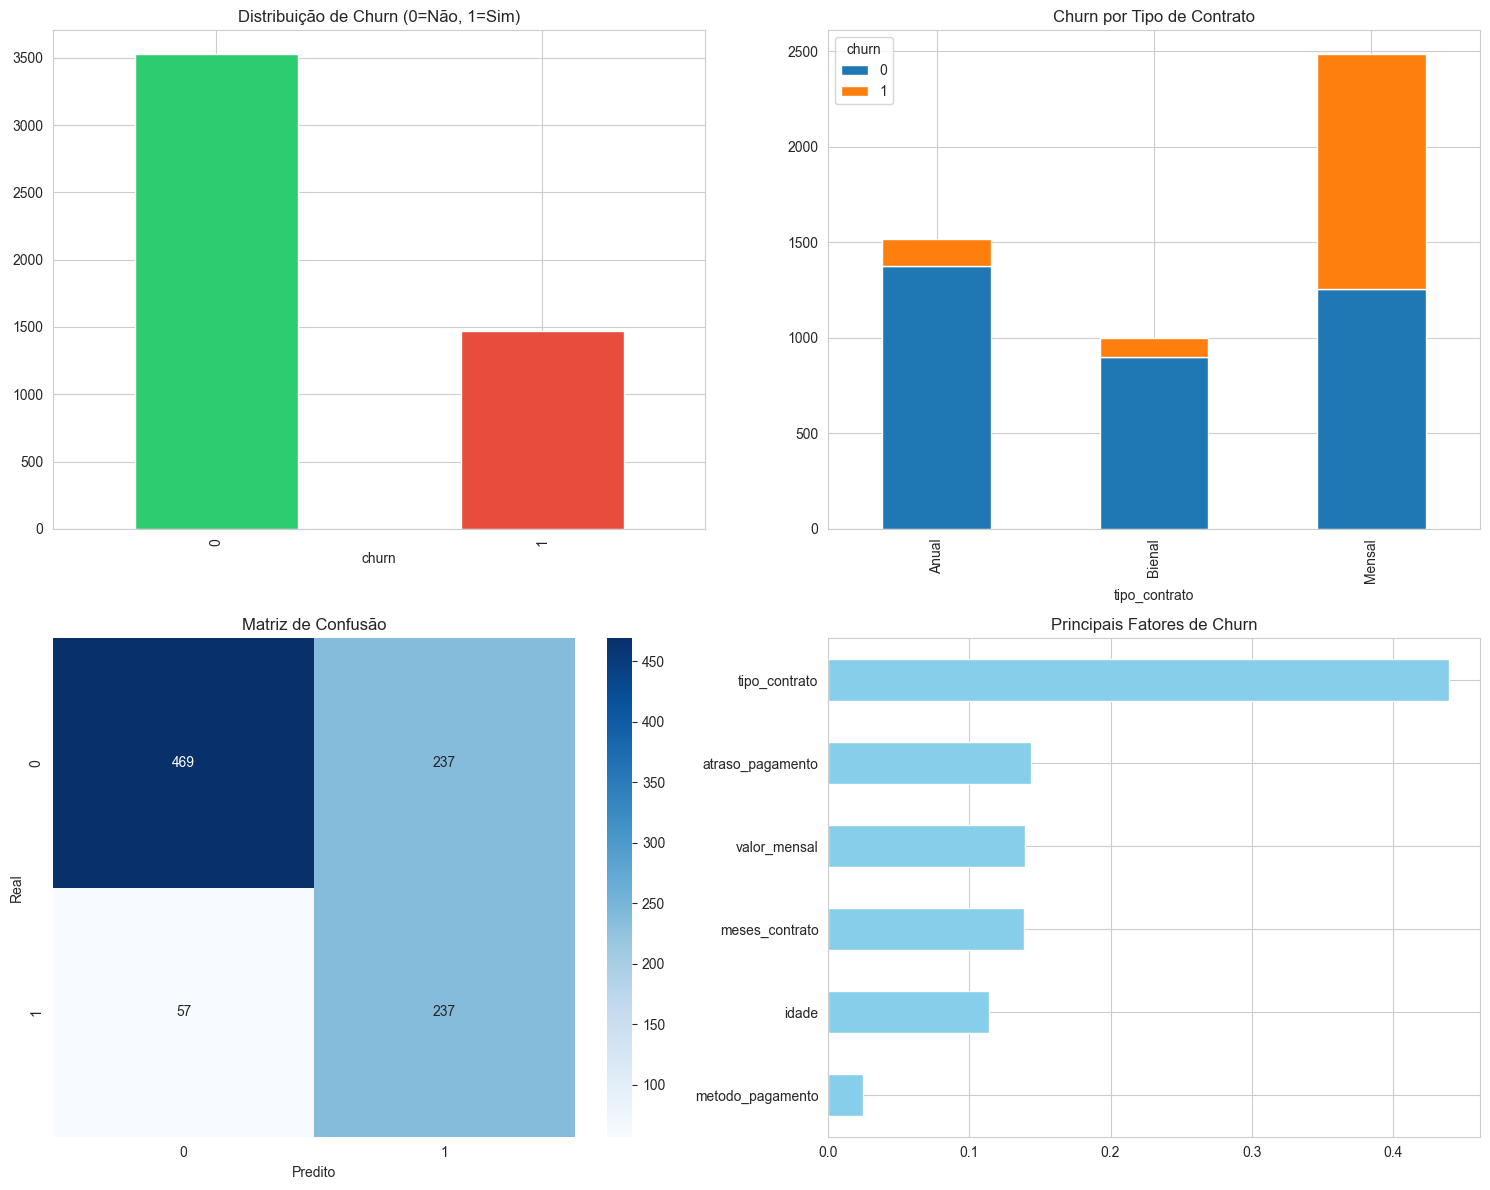

Visualizações geradas em 'dashboard_resultados.png' e lista salva.


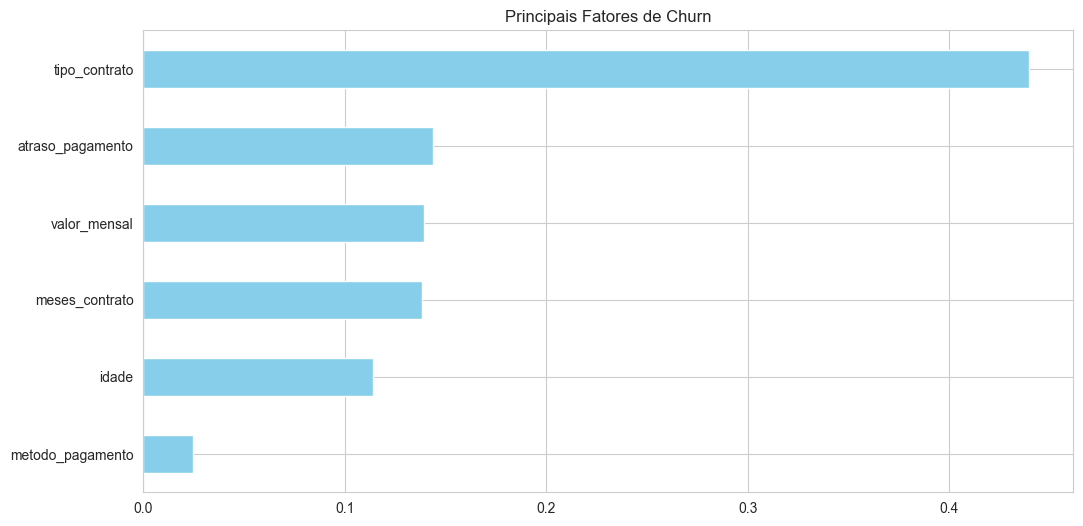

Processo concluído. Arquivos 'clientes_prioritarios.csv' e 'importancia_variaveis.png' gerados.


In [7]:
"""
PROJETO: ANÁLISE DE CHURN DE CLIENTES
Objetivo: Predição de cancelamento usando Random Forest e Gradient Boosting
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils import resample

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# ----------------------------------------------------------------------------
# 1. GERAÇÃO DA BASE DE DADOS
# ----------------------------------------------------------------------------
def gerar_dados(n=5000):
    np.random.seed(42)
    
    df = pd.DataFrame({
        'cliente_id': [f'ID_{i:05d}' for i in range(n)],
        'idade': np.random.randint(18, 80, n),
        'meses_contrato': np.random.randint(1, 72, n),
        'tipo_contrato': np.random.choice(['Mensal', 'Anual', 'Bienal'], n, p=[0.5, 0.3, 0.2]),
        'metodo_pagamento': np.random.choice(['Automatico', 'Cartao', 'Boleto'], n),
        'valor_mensal': np.random.uniform(20, 150, n).round(2),
        'atraso_pagamento': np.random.choice([0, 1], n, p=[0.8, 0.2])
    })

    # Lógica de Churn (Regras de Negócio)
    prob = np.zeros(n)
    prob += (df['tipo_contrato'] == 'Mensal') * 0.4
    prob += (df['atraso_pagamento'] == 1) * 0.3
    prob += (df['meses_contrato'] < 12) * 0.2
    
    df['churn'] = np.random.binomial(1, np.clip(prob, 0, 1))
    return df

df = gerar_dados()

# ----------------------------------------------------------------------------
# 2. PREPARAÇÃO DOS DADOS
# ----------------------------------------------------------------------------
df_proc = df.copy()

# Encoding de categorias
le = LabelEncoder()
for col in ['tipo_contrato', 'metodo_pagamento']:
    df_proc[col] = le.fit_transform(df_proc[col])

X = df_proc.drop(['cliente_id', 'churn'], axis=1)
y = df_proc['churn']

# Split e Balanceamento (Oversampling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

train_data = pd.concat([X_train, y_train], axis=1)
df_maioria = train_data[train_data.churn == 0]
df_minoria = train_data[train_data.churn == 1]

df_minoria_upsampled = resample(df_minoria, replace=True, n_samples=len(df_maioria), random_state=42)
df_final = pd.concat([df_maioria, df_minoria_upsampled])

X_train_final = df_final.drop('churn', axis=1)
y_train_final = df_final['churn']

# ----------------------------------------------------------------------------
# 3. MODELAGEM
# ----------------------------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_scaled, y_train_final)

y_pred = rf.predict(X_test_scaled)
print("Relatório de Performance (Random Forest):")
print(classification_report(y_test, y_pred))

# ----------------------------------------------------------------------------
# 4. EXPORTAÇÃO E VISUALIZAÇÃO DOS RESULTADOS
# ----------------------------------------------------------------------------

# Criando uma figura com vários subplots (estilo dashboard manual)
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribuição da variável alvo
df['churn'].value_counts().plot(kind='bar', color=['#2ecc71', '#e74c3c'], ax=ax[0,0])
ax[0,0].set_title('Distribuição de Churn (0=Não, 1=Sim)')

# 2. Churn por Tipo de Contrato
pd.crosstab(df['tipo_contrato'], df['churn']).plot(kind='bar', stacked=True, ax=ax[0,1])
ax[0,1].set_title('Churn por Tipo de Contrato')

# 3. Matriz de Confusão
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', ax=ax[1,0])
ax[1,0].set_title('Matriz de Confusão')
ax[1,0].set_xlabel('Predito')
ax[1,0].set_ylabel('Real')

# 4. Importância das Variáveis
importancias = pd.Series(rf.feature_importances_, index=X.columns).sort_values()
importancias.plot(kind='barh', color='skyblue', ax=ax[1,1])
ax[1,1].set_title('Principais Fatores de Churn')

plt.tight_layout()
plt.savefig('dashboard_resultados.png')
plt.show()

# Exportando a lista final
X_scaled_full = scaler.transform(X)
df['probabilidade'] = rf.predict_proba(X_scaled_full)[:, 1]
df[df['probabilidade'] > 0.7].to_csv('clientes_prioritarios.csv', index=False)

print("Visualizações geradas em 'dashboard_resultados.png' e lista salva.")

# Gráfico de Importância
importancias = pd.Series(rf.feature_importances_, index=X.columns).sort_values()
importancias.plot(kind='barh', color='skyblue')
plt.title('Principais Fatores de Churn')
plt.savefig('importancia_variaveis.png')
plt.show()

print("Processo concluído. Arquivos 'clientes_prioritarios.csv' e 'importancia_variaveis.png' gerados.")